In [26]:
import re
import nltk
import pandas as pd
import numpy as np
import os
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_colwidth = 50

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
def clean(text):
    """ Removes from the input text:
        - html tags, 
        - punctuations, 
        - stop words,
        - words of less than 3 characters
        - all words that are not a noun, an adjective, or a verb.

    Arguments:
        text (str) :
            The text to be cleaned

    Raises:
        TypeError: if input parameters are not of the expected type

    Returns:
        text (str) :
            The cleaned text (lowercased)
    """
    
    if not isinstance(text, str):
        raise TypeError("Argument 'text' must be a string.")
    
    # Strip the text, lowercase it, and remove the HTML tags and punctuations
    text = text.lower().strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^ 0-9a-z]', ' ', text)
    text = re.sub(r'\b(\d+\d)\b', '', text)
    text = re.sub(r'http|https|www', '', text)
    text = re.sub(r'\b[a-z]\b', '', text)
    text = re.sub(r' +', ' ', text)
    text = text.translate(text.maketrans('', '', string.punctuation)) #extra punctuations removal

    # Remove all the stop words
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend([
        'from', 're', 'also'
    ])
    stop_words = {key: True for key in set(stop_words)}
    
    # Keep only specific pos (part of speech: nouns, adjectives, and adverbs)
    keep_pos = {key: True for key in ['NN','NNS','NNP','NNPS', 'JJ', 'JJR', 'JJS','RB','RBR','RBS']}
    
    return " ".join([word 
                     for word, pos in nltk.tag.pos_tag(text.split()) 
                     if len(word) > 2 and word not in stop_words and pos in keep_pos])

In [28]:
def lemmatize(text: str, lemmatizer: nltk.stem.WordNetLemmatizer) -> str:
    """ Lemmatize the words in a sentence by:
        - mapping the POS tag to each word,
        - lemmatize the word.

    Arguments:
        sentence (str):
            The sentence in which the words need to be lemmatized
        lemmatizer:
            Lemmatizer function

   Raises:
        TypeError: if input parameters are not of the expected type

    Returns:
        Lemmatized text
    ----------------------------------------------------------------------------------------
    """
    
    if not isinstance(text, str):
        raise TypeError("Argument 'text' must be a string.")

    lemmas = []
    tag_dict = {
        "J": nltk.corpus.wordnet.ADJ,
        "N": nltk.corpus.wordnet.NOUN,
        "V": nltk.corpus.wordnet.VERB,
        "R": nltk.corpus.wordnet.ADV
    }
    
    tokenized_words = nltk.word_tokenize(text)
    for tokenized_word in tokenized_words:
        tag = nltk.tag.pos_tag([tokenized_word])[0][1][0].upper() # Map POS tag to first character lemmatize() accepts
        wordnet_pos = tag_dict.get(tag, nltk.corpus.wordnet.NOUN)
        lemma = lemmatizer.lemmatize(tokenized_word, wordnet_pos)
        lemmas.append(lemma)
    
    return " ".join(lemmas)

In [29]:
articles = pd.read_csv("../Data/articles.csv")

articles = articles.dropna(thresh=3)

print(f"Number of records: {len(articles)}")

articles.head()



Number of records: 13515


,Unnamed: 0,article_text,article_date
0,0,A leading Brexiter has claimed to have seen an...,25/10/2018
1,1,L/Cpl Kat Dixon did not hesitate when asked wh...,25/10/2018
2,2,He was a master at bluffing his way through po...,25/10/2018
3,3,The home secretary has apologised to immigrant...,25/10/2018
4,4,A Chinese journalist has been charged with com...,25/10/2018


In [30]:
articles["n_words"] = articles["article_text"].apply(lambda text: len(text.split(" ")))

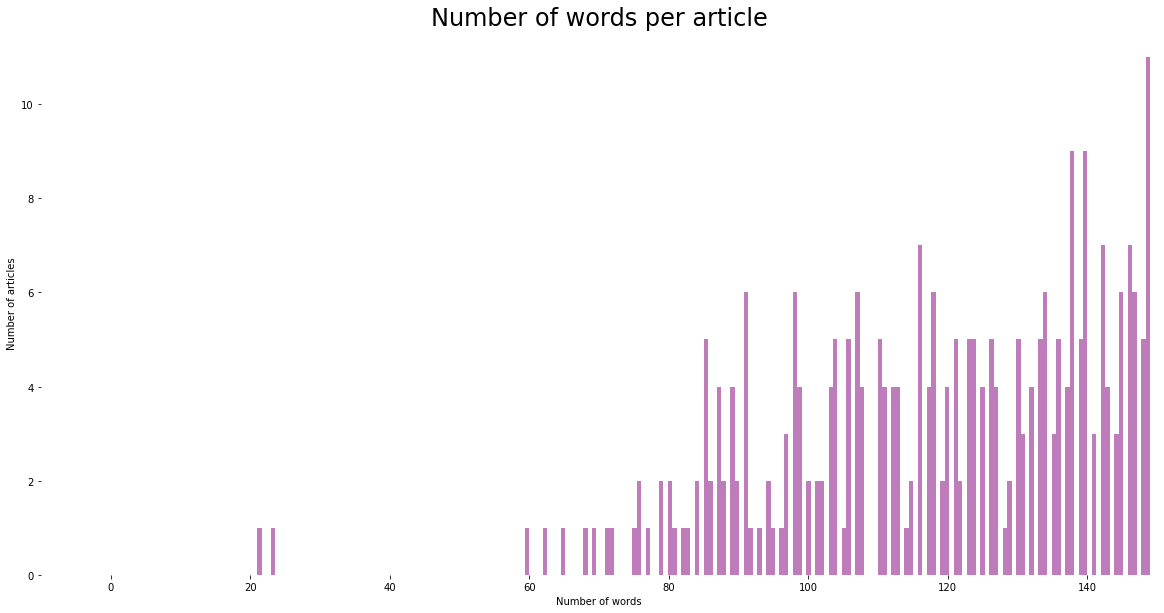

In [31]:
import matplotlib.pyplot as plt

# clean article word count
plt.figure(figsize=(20, 10))
plt.hist(articles[articles["n_words"] < 150].n_words, bins = 200, color = ["#bf7cbb"])
plt.gca().set(xlim=(-10, 150), ylabel='Number of articles', xlabel='Number of words')
plt.box(False)
plt.title('Number of words per article', fontdict=dict(size=24))
plt.show()

In [32]:
# Keep only the articles that contain more than 50 words

articles = articles[articles["n_words"] > 50]

In [33]:
articles["article_clean"] = articles["article_text"].apply(clean)

lemmatizer = nltk.stem.WordNetLemmatizer()
articles["article_clean"] = articles["article_clean"].apply(lambda x: lemmatize(x, lemmatizer)) 

articles["n_words_clean"] = articles["article_clean"].apply(lambda x: len(x.split(" ")))

articles.head()


,Unnamed: 0,article_text,article_date,n_words,article_clean,n_words_clean
0,0,A leading Brexiter has claimed to have seen an...,25/10/2018,558,brexiter extract draft withdrawal agreement vo...,182
1,1,L/Cpl Kat Dixon did not hesitate when asked wh...,25/10/2018,562,cpl kat dixon bad thing challenger tank men sm...,173
2,2,He was a master at bluffing his way through po...,25/10/2018,620,master way police check airport terminal array...,234
3,3,The home secretary has apologised to immigrant...,25/10/2018,1014,home secretary immigrant afghan national briti...,334
4,4,A Chinese journalist has been charged with com...,25/10/2018,86,chinese journalist common assault incident con...,33


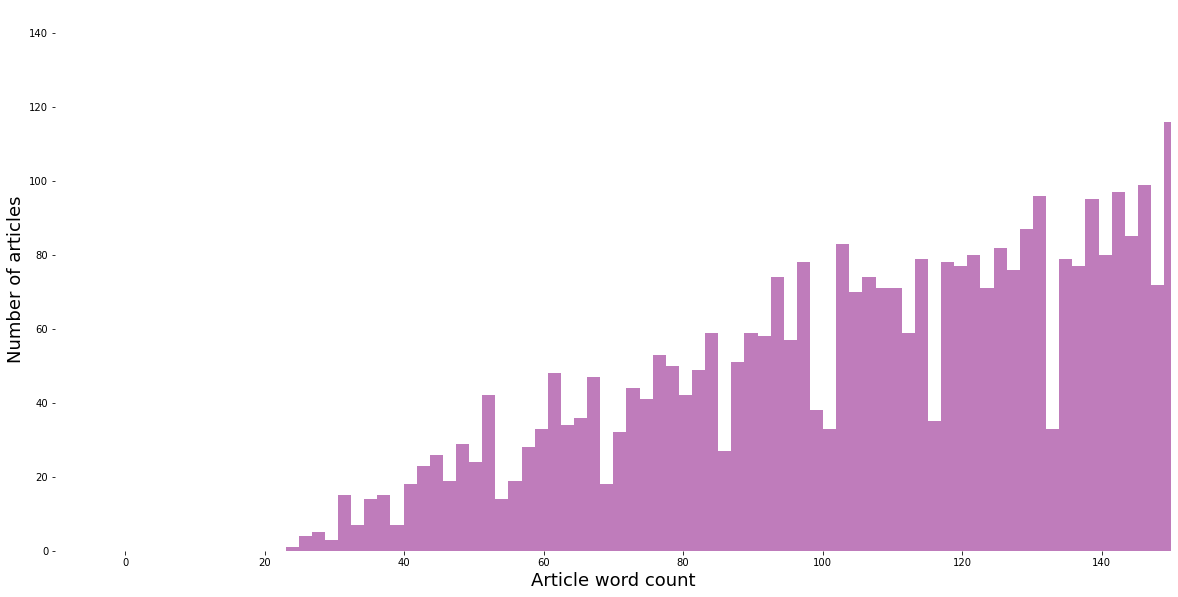

In [34]:
import matplotlib.pyplot as plt

# clean article word count
plt.figure(figsize=(20, 10))
plt.hist(articles[articles["n_words_clean"] < 400].n_words_clean, 
         bins = 200, 
         color = ["#bf7cbb"])
plt.xlim((-10, 150))
plt.xlabel("Article word count", fontsize=18)
plt.ylabel("Number of articles", fontsize=18)
plt.box(False)
plt.show()

In [35]:
articles.to_csv("../Data/Articles_data/cleaned_articles.csv", index=False)

In [23]:
articles["date"] = pd.to_datetime(articles["article_date"])

In [25]:
len(articles.article_date.unique())

962